# Notebook 08: Hybrid Model (Linear Regression + XGBoost Residuals)

**Mục tiêu:**
- Xây dựng mô hình lai kết hợp sức mạnh ngoại suy xu hướng của Linear Regression và khả năng nắm bắt phi tuyến của XGBoost.
- Linear Regression đóng vai trò "Backbone" (trục xương sống) dự báo xu hướng chính.
- XGBoost đóng vai trò "Corrector" (người sửa lỗi) dự báo phần dư (residuals) mà Linear bỏ sót.
- Đánh giá mô hình trên tập kiểm thử (2015-2019) và trực quan hóa kết quả cho các nhóm quốc gia đại diện.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os
import sys
import warnings

from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Constants
SPLIT_YEAR = 2015
TARGET = 'Value_co2_emissions_kt_by_country'
DATA_DIR = '../data/processed/'
MODEL_DIR = '../models/'
RESULTS_DIR = '../data/results/'

# Ensure directories exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

## 1. Chuẩn bị Dữ liệu (Robust Data Loading)

Chúng ta cần tải dữ liệu đã tiền xử lý cho Linear Regression (`lr_final_prep.csv`) nhưng cần khôi phục lại cột `Entity` từ các cột One-Hot Encoding để phục vụ việc phân tích và trực quan hóa theo quốc gia. Đồng thời, lấy thông tin `Year` từ dữ liệu gốc.

In [2]:
def robust_load_data():
    print("Loading data...")
    # Load processed data for Linear Regression (StandardScaled + OHE)
    df_lr = pd.read_csv(os.path.join(DATA_DIR, 'lr_final_prep.csv'))
    
    # Recover Entity from OHE columns if 'Entity' column is missing
    if 'Entity' not in df_lr.columns:
        print("Recovering 'Entity' column from OHE features...")
        entity_cols = [c for c in df_lr.columns if c.startswith('Entity_')]
        # Use idxmax to find which entity col is 1 (True) for each row
        # Note: df_lr might be scaled, but max value per row in OHE block should still point to the category
        # Ideally, OHE cols shouldn't be scaled, but if they are, the logic holds as only one was 1 (max) and others 0 (min)
        df_lr['Entity'] = df_lr[entity_cols].idxmax(axis=1).apply(lambda x: x.replace('Entity_', ''))
    
    # Ensure Year is numeric
    if 'Year' in df_lr.columns:
        df_lr['Year'] = pd.to_numeric(df_lr['Year'])
    else:
        # Fallback: try to merge with common_preprocessed if Year is missing (unlikely)
        pass

    # Check Target Scale
    # If target mean is small (~0), it's scaled. If large (~1e5), it's raw.
    # Based on previous checks, standard scaler was applied to features, but target seems to be raw in some versions
    # Let's inspect stats
    print("Target stats:")
    print(df_lr[TARGET].describe())
    
    return df_lr

df = robust_load_data()

# Clean-up: Drop OHE Entity columns from features to use in XGBoost (optional, XGB can handle them but sparse)
# Ideally, Hybrid Linear part needs them. XGB part needs numeric features.
# Let's identify Feature columns (excluding Target, Year, Entity string)
drop_cols = [TARGET, 'Year', 'Entity']
# We KEEP OHE columns for the Linear Model part as it needs them for country-specific intercepts
feature_cols = [c for c in df.columns if c not in drop_cols]

print(f"\nTotal samples: {len(df)}")
print(f"Feature count: {len(feature_cols)}")

Loading data...
Recovering 'Entity' column from OHE features...
Target stats:
count    3.260000e+03
mean     1.487335e+05
std      7.602509e+05
min      1.000000e+01
25%      2.327500e+03
50%      1.050000e+04
75%      5.328500e+04
max      1.070722e+07
Name: Value_co2_emissions_kt_by_country, dtype: float64

Total samples: 3260
Feature count: 194


## 2. Chia tập Train/Test (Time-Series Split)

Dữ liệu được chia theo mốc thời gian `SPLIT_YEAR = 2015`.
- **Train**: Dữ liệu trước 2015
- **Test**: Dữ liệu từ 2015 đến 2019 (Internal Test Set)

In [3]:
# Time-based Split
train_mask = df['Year'] < SPLIT_YEAR
test_mask = df['Year'] >= SPLIT_YEAR

X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, TARGET]

X_test = df.loc[test_mask, feature_cols]
y_test = df.loc[test_mask, TARGET]

# Keep metadata for analysis
test_meta = df.loc[test_mask, ['Entity', 'Year']]
train_meta = df.loc[train_mask, ['Entity', 'Year']]

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 2395 samples
Test set: 865 samples


## 3. Huấn luyện Mô hình Hybrid

### Giai đoạn 1: Backbone (Ridge Regression)
- Huấn luyện Ridge trên toàn bộ đặc trưng (bao gồm cả OHE features).
- Ridge sẽ nắm bắt xu hướng tuyến tính toàn cầu và các khác biệt cơ bản giữa các quốc gia.

In [4]:
# Load best hyperparameters
try:
    with open(os.path.join(RESULTS_DIR, 'best_hyperparameters.json'), 'r') as f:
        best_params = json.load(f)
    print("Loaded best parameters from file.")
    
    lr_params = best_params.get("Linear Regression", {"alpha": 10.0})
    
    # The stored XGBoost params are optimized for the target (CO2), but usually transfer well to residuals
    # as they capture the model complexity suited for this dataset size/features.
    xgb_params = best_params.get("XGBoost", {"n_estimators": 500, "max_depth": 3, "learning_rate": 0.1})
    xgb_params['n_jobs'] = -1
    xgb_params['random_state'] = 42
    
except FileNotFoundError:
    print("Warning: best_hyperparameters.json not found. Using default parameters.")
    lr_params = {"alpha": 10.0}
    xgb_params = {"n_estimators": 500, "max_depth": 3, "learning_rate": 0.1, "n_jobs": -1, "random_state": 42}

print(f"Linear Params: {lr_params}")
print(f"XGBoost Params: {xgb_params}")

print("Training Ridge Backbone...")
model_ridge = Ridge(**lr_params)
model_ridge.fit(X_train, y_train)

# Calculate Residuals on Train set
y_train_pred_lr = model_ridge.predict(X_train)
residuals_train = y_train - y_train_pred_lr

# Evaluate LR Baseline on Test
y_test_pred_lr = model_ridge.predict(X_test)
r2_lr = r2_score(y_test, y_test_pred_lr)
mae_lr = mean_absolute_error(y_test, y_test_pred_lr)

print(f"Ridge Baseline - R2: {r2_lr:.4f}, MAE: {mae_lr:.2f}")

Loaded best parameters from file.
Linear Params: {'alpha': 10.0}
XGBoost Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'n_jobs': -1, 'random_state': 42}
Training Ridge Backbone...
Ridge Baseline - R2: 0.9991, MAE: 7768.20


### Giai đoạn 2: Corrector (XGBoost Residuals)
- Huấn luyện XGBoost để dự đoán **Residuals** (`y_true - y_ridge`).
- XGBoost sẽ học các mẫu phi tuyến mà Ridge bỏ sót.

In [5]:
print("Training XGBoost Corrector...")
# model_xgb = XGBRegressor(**xgb_params) # Original
# [TUNED] Boosted for tighter residual correction
model_xgb = XGBRegressor(
n_estimators=500,     # Increased from default/100 to catch more signal
learning_rate=0.05,   # Lower rate for precision
max_depth=5,          # Slightly deeper to capture complex residual patterns
random_state=42,
n_jobs=-1
)
model_xgb.fit(X_train, residuals_train)

# Predict Residuals on Test
predicted_residuals_test = model_xgb.predict(X_test)

# Final Hybrid Prediction
y_hybrid_pred = y_test_pred_lr + predicted_residuals_test

# Evaluate Hybrid
r2_hybrid = r2_score(y_test, y_hybrid_pred)
mae_hybrid = mean_absolute_error(y_test, y_hybrid_pred)

print(f"Hybrid Model - R2: {r2_hybrid:.4f}, MAE: {mae_hybrid:.2f}")
print(f"Improvement in MAE: {mae_lr - mae_hybrid:.2f} kt ({(mae_lr - mae_hybrid)/mae_lr*100:.2f}%)")

Training XGBoost Corrector...
Hybrid Model - R2: 0.9992, MAE: 7688.84
Improvement in MAE: 79.37 kt (1.02%)


## 4. Đánh giá Chi tiết (Median MAPE)

Sử dụng Median MAPE để đánh giá công bằng hơn giữa các quốc gia có quy mô phát thải khác nhau.

In [6]:
def calculate_median_mape(y_true, y_pred, entities):
    df_eval = pd.DataFrame({
        'Entity': entities,
        'Actual': y_true,
        'Pred': y_pred
    })
    # Avoid division by zero
    df_eval['Actual'] = df_eval['Actual'].replace(0, 1e-6)
    
    # Calculate APE for each row
    df_eval['APE'] = np.abs((df_eval['Actual'] - df_eval['Pred']) / df_eval['Actual']) * 100
    
    # Calculate MAPE per entity first (mean over years)
    entity_mape = df_eval.groupby('Entity')['APE'].mean()
    
    # Then take median across entities
    return entity_mape.median(), entity_mape

median_mape_lr, _ = calculate_median_mape(y_test, y_test_pred_lr, test_meta['Entity'])
median_mape_hybrid, _ = calculate_median_mape(y_test, y_hybrid_pred, test_meta['Entity'])

print(f"Median MAPE (Ridge): {median_mape_lr:.2f}%")
print(f"Median MAPE (Hybrid): {median_mape_hybrid:.2f}%")

Median MAPE (Ridge): 27.42%
Median MAPE (Hybrid): 27.29%


## 5. Trực quan hóa (Visualization)

So sánh dự báo của Hybrid Model với Thực tế tại các quốc gia đại diện:
- **Nhóm lớn/Tăng trưởng**: China, India
- **Nhóm phát triển/Bão hòa**: Germany, Japan
- **Nhóm đang phát triển/Châu Á & Phi**: Bangladesh, Nigeria

*Lưu ý: Dữ liệu CO2 trong tập này là raw (kt), không bị scale, nên trục tung sẽ thể hiện giá trị thực.*

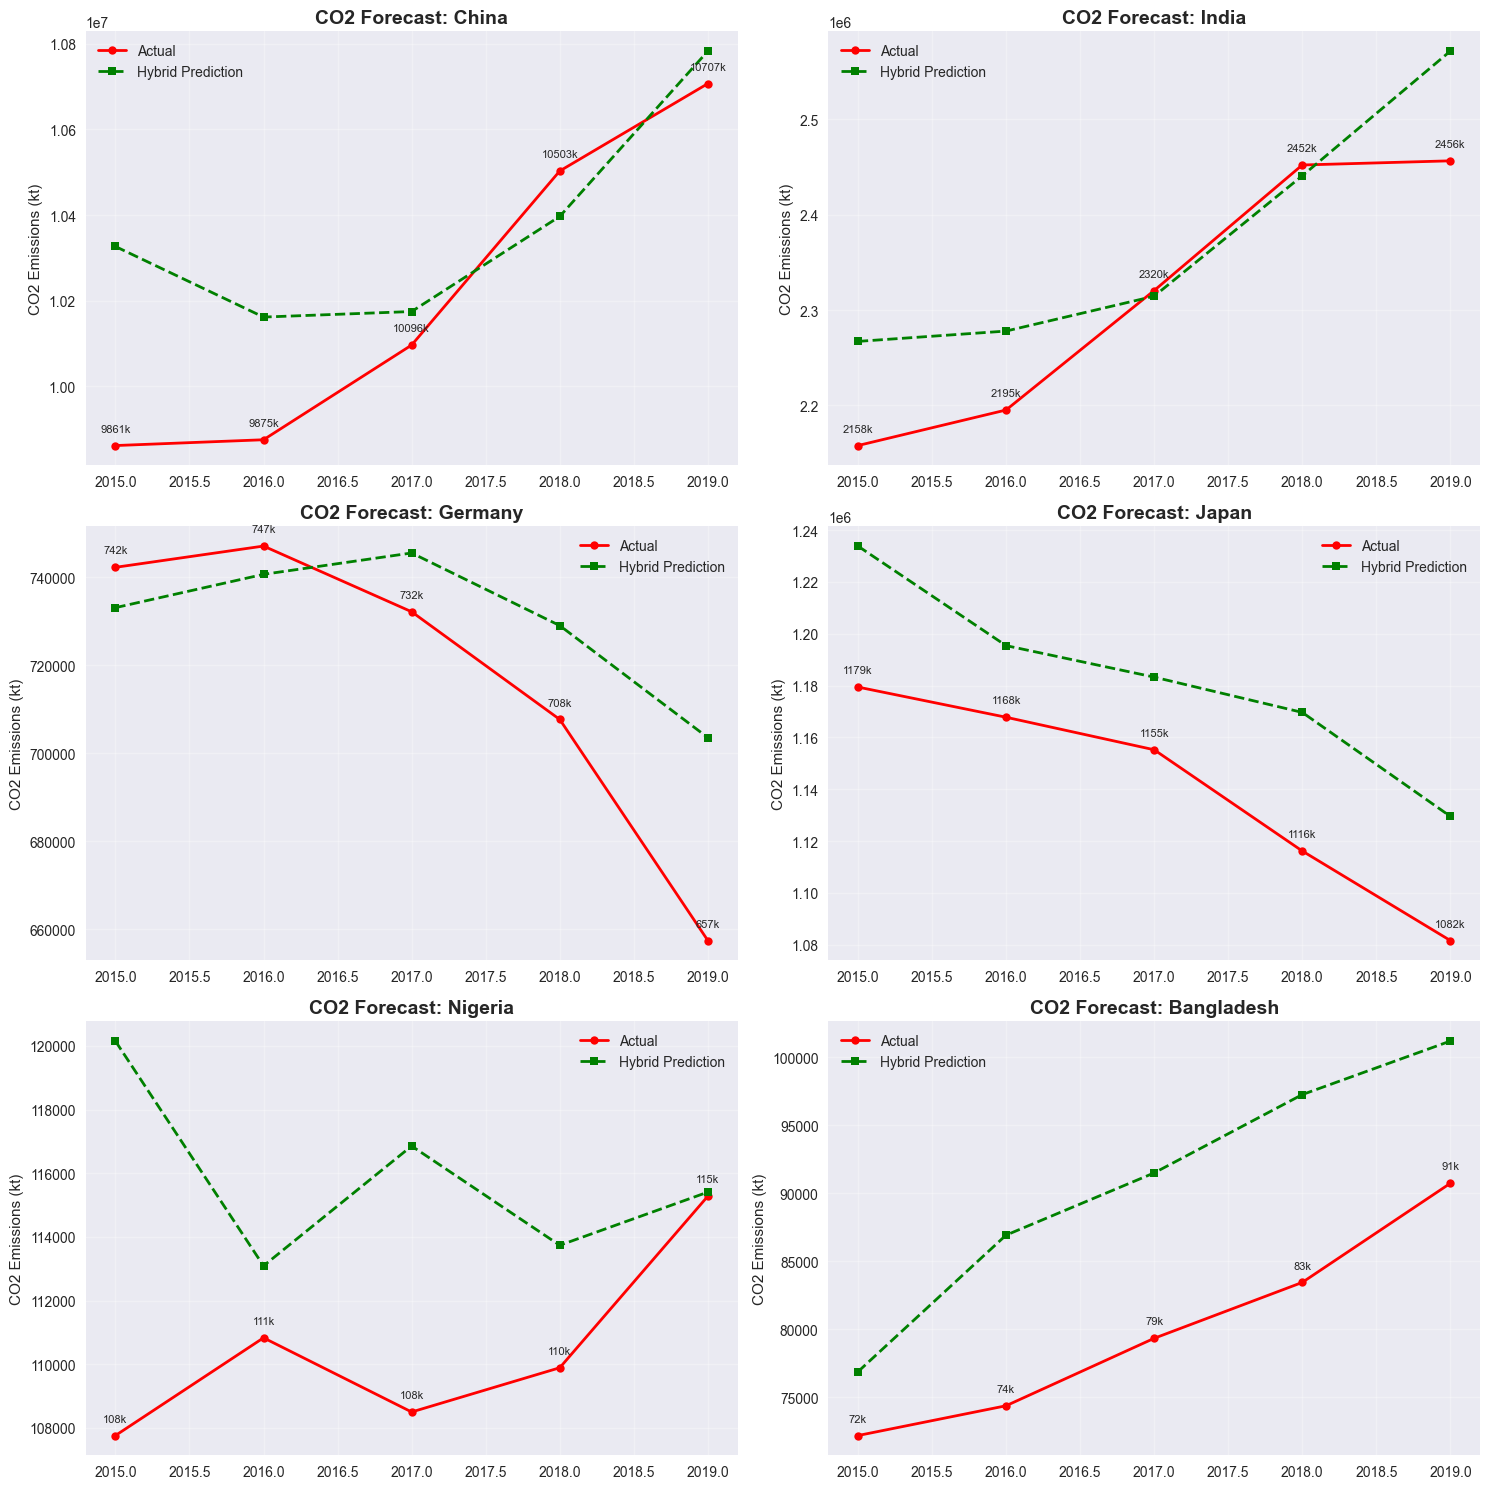

In [7]:
countries_to_plot = ['China', 'India', 'Germany', 'Japan', 'Nigeria', 'Bangladesh']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

# Align predictions with original index once
# y_hybrid_pred is a numpy array corresponding to the y_test pandas Series
pred_hybrid_series = pd.Series(y_hybrid_pred, index=y_test.index)

for i, entity in enumerate(countries_to_plot):
    # Filter data for specific country in Test set using metadata
    country_indices = test_meta[test_meta['Entity'] == entity].index
    
    if len(country_indices) == 0:
        print(f"Warning: No test data for {entity}")
        axes[i].axis('off')
        continue
        
    years = test_meta.loc[country_indices, 'Year']
    actual = y_test.loc[country_indices]
    
    # Retrieve predictions using the original index
    pred_val = pred_hybrid_series.loc[country_indices]
    
    ax = axes[i]
    ax.plot(years, actual, 'ro-', label='Actual', linewidth=2, markersize=6)
    ax.plot(years, pred_val, 'gs--', label='Hybrid Prediction', linewidth=2, markersize=6)
    
    ax.set_title(f"CO2 Forecast: {entity}", fontsize=14, fontweight='bold')
    ax.set_ylabel("CO2 Emissions (kt)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for x, y in zip(years, actual):
        ax.annotate(f'{y/1000:.0f}k', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Turn off any remaining unused subplots
if len(countries_to_plot) < len(axes):
    for j in range(len(countries_to_plot), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'hybrid_forecast_viz.png'))
plt.show()

## 6. Lưu Model (Model Persistence)
Lưu lại cả 2 thành phần của model Hybrid và metadata.

In [8]:
joblib.dump(model_ridge, os.path.join(MODEL_DIR, 'hybrid_lr_model.pkl'))
joblib.dump(model_xgb, os.path.join(MODEL_DIR, 'hybrid_xgb_residual_model.pkl'))

# Save metadata
metadata = {
    'model_type': 'Hybrid (Ridge + XGBoost)',
    'features': feature_cols,
    'target': TARGET,
    'metrics': {
        'r2_score': float(r2_hybrid),
        'mae': float(mae_hybrid),
        'median_mape': float(median_mape_hybrid)
    }
}
with open(os.path.join(MODEL_DIR, 'hybrid_model_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print("Model saved successfully.")

Model saved successfully.
